In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv('PLD.csv')

data

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-11-24,23.000000,23.000000,22.250000,22.750000,7.982285,541600
1,1997-11-25,22.875000,23.000000,22.687500,23.000000,8.070007,425000
2,1997-11-26,23.000000,23.000000,22.750000,22.750000,7.982285,165200
3,1997-11-28,22.750000,23.000000,22.750000,23.000000,8.070007,60500
4,1997-12-01,23.062500,23.125000,23.000000,23.062500,8.091936,120300
...,...,...,...,...,...,...,...
6375,2023-03-28,116.129997,117.160004,115.629997,116.650002,114.279823,1853300
6376,2023-03-29,118.480003,119.989998,118.099998,119.879997,117.444191,2591100
6377,2023-03-30,121.000000,122.269997,120.620003,121.919998,119.442734,3384600
6378,2023-03-31,122.970001,124.889999,122.690002,124.769997,122.234825,5305300


In [60]:
data = data[['Date', 'Close']]
data

,Date,Close
0,1997-11-24,22.750000
1,1997-11-25,23.000000
2,1997-11-26,22.750000
3,1997-11-28,23.000000
4,1997-12-01,23.062500
...,...,...
6375,2023-03-28,116.650002
6376,2023-03-29,119.879997
6377,2023-03-30,121.919998
6378,2023-03-31,124.769997


In [61]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

<ipython-input-62-27440ea654b2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'])


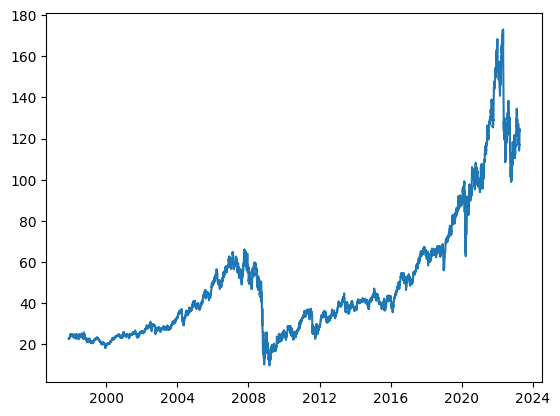

In [62]:
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [63]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    df.dropna(inplace=True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-12-04,23.000000,23.000000,23.000000,23.062500,23.000000,22.750000,23.000000,22.750000
1997-12-05,23.062500,23.000000,23.000000,23.000000,23.062500,23.000000,22.750000,23.000000
1997-12-08,23.187500,23.062500,23.000000,23.000000,23.000000,23.062500,23.000000,22.750000
1997-12-09,23.187500,23.187500,23.062500,23.000000,23.000000,23.000000,23.062500,23.000000
1997-12-10,23.062500,23.187500,23.187500,23.062500,23.000000,23.000000,23.000000,23.062500
...,...,...,...,...,...,...,...,...
2023-03-28,116.650002,117.059998,117.029999,114.150002,114.120003,118.360001,118.699997,116.029999
2023-03-29,119.879997,116.650002,117.059998,117.029999,114.150002,114.120003,118.360001,118.699997
2023-03-30,121.919998,119.879997,116.650002,117.059998,117.029999,114.150002,114.120003,118.360001


In [64]:
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 23.      ,  23.      ,  23.      , ...,  22.75    ,  23.      ,
         22.75    ],
       [ 23.0625  ,  23.      ,  23.      , ...,  23.      ,  22.75    ,
         23.      ],
       [ 23.1875  ,  23.0625  ,  23.      , ...,  23.0625  ,  23.      ,
         22.75    ],
       ...,
       [121.919998, 119.879997, 116.650002, ..., 114.150002, 114.120003,
        118.360001],
       [124.769997, 121.919998, 119.879997, ..., 117.029999, 114.150002,
        114.120003],
       [123.769997, 124.769997, 121.919998, ..., 117.059998, 117.029999,
        114.150002]])

In [65]:
shifted_df_as_np.shape

(6373, 8)

In [66]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.8373446 , -0.8373446 , -0.8373446 , ..., -0.84040663,
        -0.8373446 , -0.84040663],
       [-0.83657909, -0.8373446 , -0.8373446 , ..., -0.8373446 ,
        -0.84040663, -0.8373446 ],
       [-0.83504807, -0.83657909, -0.8373446 , ..., -0.83657909,
        -0.8373446 , -0.84040663],
       ...,
       [ 0.37424216,  0.34925593,  0.30969447, ...,  0.2790741 ,
         0.27870667,  0.33063879],
       [ 0.40914937,  0.37424216,  0.34925593, ...,  0.31434873,
         0.2790741 ,  0.27870667],
       [ 0.39690122,  0.40914937,  0.37424216, ...,  0.31471616,
         0.31434873,  0.2790741 ]])

In [67]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((6373, 7), (6373,))

In [68]:
X = dc(np.flip(X, axis=1))
X

array([[-0.84040663, -0.8373446 , -0.84040663, ..., -0.83657909,
        -0.8373446 , -0.8373446 ],
       [-0.8373446 , -0.84040663, -0.8373446 , ..., -0.8373446 ,
        -0.8373446 , -0.8373446 ],
       [-0.84040663, -0.8373446 , -0.83657909, ..., -0.8373446 ,
        -0.8373446 , -0.83657909],
       ...,
       [ 0.33063879,  0.27870667,  0.2790741 , ...,  0.31471616,
         0.30969447,  0.34925593],
       [ 0.27870667,  0.2790741 ,  0.31434873, ...,  0.30969447,
         0.34925593,  0.37424216],
       [ 0.2790741 ,  0.31434873,  0.31471616, ...,  0.34925593,
         0.37424216,  0.40914937]])

In [69]:
split_index = int(len(X) * 0.95)

split_index

6054

In [70]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6054, 7), (319, 7), (6054,), (319,))

In [71]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6054, 7, 1), (319, 7, 1), (6054, 1), (319, 1))

In [72]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([6054, 7, 1]),
 torch.Size([319, 7, 1]),
 torch.Size([6054, 1]),
 torch.Size([319, 1]))

In [73]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [74]:
train_dataset

In [75]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [76]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [77]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [78]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [79]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [80]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.171
Batch 200, Loss: 0.011
Batch 300, Loss: 0.004

Val Loss: 0.022
***************************************************

Epoch: 2
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.014
***************************************************

Epoch: 3
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.010
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000
Batch 300, Loss: 0.001

Val Loss: 0.007
***************************************************

Epoch: 5
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.005
***************************************************

Epoch: 6
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.004
***************************************************

Epoch: 7
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.003
*****************

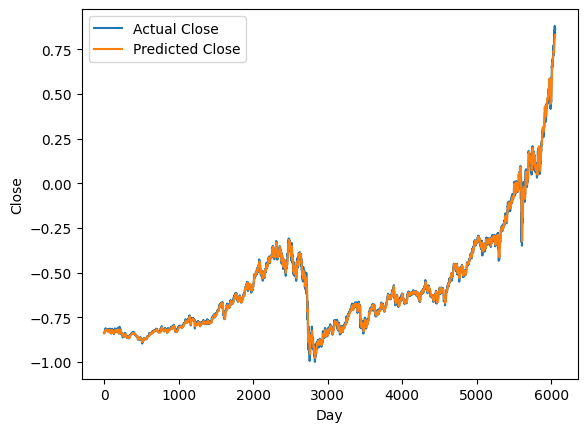

In [81]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [82]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([ 22.80948042,  22.82648856,  22.84355023, ..., 158.84742981,
       158.73887455, 158.99391395])

In [83]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 23.0000008 ,  23.06250025,  23.18749914, ..., 160.78999317,
       162.25999299, 161.75000179])

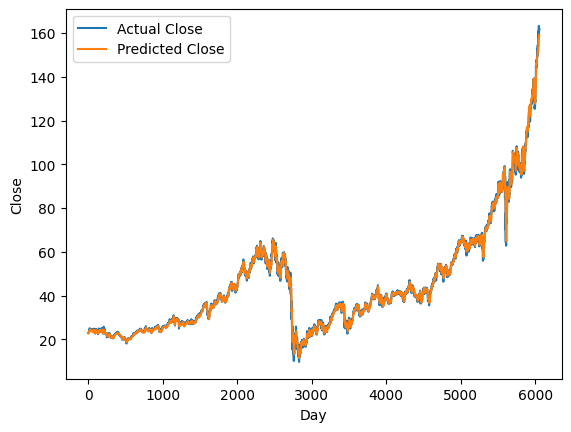

In [84]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [85]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([159.06950407, 160.05130452, 160.62534755, 161.51600967,
       162.17034378, 162.72878506, 162.29876376, 161.15223009,
       159.50122861, 158.09835621, 156.3258694 , 154.8972147 ,
       153.8567544 , 153.24742982, 152.86578561, 152.55768276,
       152.55793582, 152.65395031, 152.8846284 , 153.38509601,
       153.14112285, 153.18655089, 152.60810862, 151.35993974,
       152.30252657, 153.29855644, 153.05722089, 154.01488389,
       154.37189914, 153.91374993, 153.32766251, 152.5496629 ,
       153.10374387, 151.59246708, 149.94651207, 148.53937182,
       147.69709653, 146.7558869 , 145.79503639, 144.80131807,
       144.22319698, 143.37750059, 143.60849013, 145.24074616,
       145.56749714, 145.84865948, 146.62197759, 147.70258585,
       148.8310067 , 148.9936425 , 148.46929536, 149.19549678,
       149.81601899, 149.27923815, 149.29159399, 149.9969428 ,
       151.24713124, 152.68695924, 154.49718028, 155.37131117,
       156.02518297, 156.09476306, 155.76630883, 155.87

In [86]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([165.88999759, 165.78999264, 167.67999379, 167.97000329,
       168.36000314, 164.89999235, 160.99999871, 157.64999337,
       156.57000801, 153.72999387, 153.0200025 , 152.99000588,
       153.24000366, 153.14999434, 152.74000323, 153.42999361,
       153.58999667, 154.13999958, 155.42999534, 153.3099974 ,
       153.96000526, 151.72000137, 148.61000306, 155.07000671,
       156.82000579, 153.52000293, 157.33000185, 156.44000157,
       153.49000631, 152.05000312, 151.19000432, 155.36999724,
       148.42999414, 146.3099962 , 145.33999682, 145.61999609,
       144.3800028 , 143.27999698, 142.55000462, 142.3699957 ,
       140.75999382, 143.33000432, 148.44999513, 145.85000748,
       145.75999329, 147.63999881, 149.58000244, 150.83999672,
       148.91000332, 146.99000555, 150.47999835, 151.08000374,
       147.83000336, 149.16999673, 151.83999758, 154.57000627,
       156.66000273, 160.16000577, 158.91999788, 158.67000009,
       157.2299969 , 155.88999866, 157.33000185, 160.35

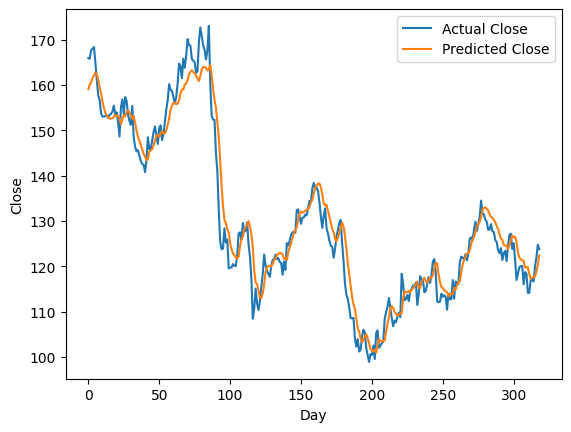

In [87]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
